In [296]:
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print
    
def init_distributed():

    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    dist_url = "env://" # default
    # only works with torch.distributed.launch // torch.run
    rank = int(os.environ["RANK"])
    world_size = int(os.environ['WORLD_SIZE'])
    local_rank = int(os.environ['LOCAL_RANK'])

    dist.init_process_group(
            backend="nccl",
            init_method=dist_url,
            world_size=world_size,
            rank=rank)

    # this will make all .cuda() calls work properly
    try:
        torch.cuda.set_device(local_rank)
    except:
        print("error at", local_rank)
    # synchronizes all the threads to reach this point before moving on
    dist.barrier()
    setup_for_distributed(rank == 0)

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from glob import glob
import copy
import time
import math
import command
import random
import sys
import h5py

#os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'
os.environ['NO_ALBUMENTATIONS_UPDATE'] = '1'

import cv2
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 12, 8

from skimage import img_as_ubyte
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import *
from sklearn.metrics import *

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
#import segmentation_models_pytorch_3d as smp
import timm
from torchtoolbox.tools import mixup_data, mixup_criterion
import torchvision as tv
from torch_ema import ExponentialMovingAverage

from transformers import get_cosine_schedule_with_warmup

import torch.distributed as dist

import logging
logging.getLogger('timm').setLevel(logging.WARNING)

#import redis
#import pickle
#redis_cache = redis.StrictRedis(host='localhost', port=6379, db=0)
#redis_cache.flushdb()

In [297]:
class CFG:
    DDP = 1
    DDP_INIT_DONE = 0
    N_GPUS = 2
    FOLD = 0
    FULLDATA = 0
    
    model_name = -1
    V = -1
    
    OUTPUT_FOLDER = f"./data/classification_stage1/{model_name}_v{V}"
    
    seed = 3407
    
    device = torch.device('cuda')
    
    n_folds = 4
    
    image_size = [512, 512]
    
    train_batch_size = 32
    valid_batch_size = 32
    acc_steps = 1
    
    lr = 3e-4
    wd = 1e-5
    ema_decay_per_epoch = 0.3
    freeze_epochs = 0
    n_epochs = 10
    n_warmup_steps = 0
    upscale_steps = 1.3
    validate_every = 1
    
    epoch = 0
    global_step = 0
    literal_step = 0
    
    autocast = True
    
    workers = 4

if CFG.FULLDATA:
    CFG.seed = CFG.FOLD
    
OUTPUT_FOLDER = CFG.OUTPUT_FOLDER
        
CFG.cache_dir = CFG.OUTPUT_FOLDER + f'/cache/'
os.makedirs(CFG.cache_dir, exist_ok=1)

seed_everything(CFG.seed)

In [368]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    changes = np.where(pixels[1:] != pixels[:-1])[0]
    starts = changes[::2]
    lengths = changes[1::2] - starts
    return list(zip(starts, lengths))


def rle_decode(rle, shape):
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    if not len(rle): return mask.reshape(shape)
    
    for start, length in rle:
        mask[start:start + length] = 1
    return mask.reshape(shape)

def crop_mask_with_quantile(mask, quantile=0.99):
    y_indices, x_indices = np.where(mask == 1)

    if len(x_indices) == 0 or len(y_indices) == 0:
        return None, None, None, None

    x1 = np.quantile(x_indices, 1 - quantile)
    x2 = np.quantile(x_indices, quantile)
    y1 = np.quantile(y_indices, 1 - quantile)
    y2 = np.quantile(y_indices, quantile)
    
    x1, x2, y1, y2 = int(x1)/255, int(x2)/255, int(y1)/255, int(y2)/255
    
    return x1, y1, x2, y2

In [374]:
CFG.n_classes = 1

class SMPModel(nn.Module):
    def __init__(self, pretrained=True, drop=0.):
        super(SMPModel, self).__init__()
        
        segmentor = smp.Unet(encoder_name=f"tu-{CFG.model_name}", encoder_weights='imagenet', in_channels=3, classes=CFG.n_classes, aux_params={'classes': CFG.n_classes})
        self.segmentor = segmentor
        
        self.encoder = segmentor.encoder
        self.decoder = segmentor.decoder
        self.segmentation_head = segmentor.segmentation_head
        
        self.bridge = nn.Conv2d(256, 1280, kernel_size=(3, 3))
        
        feats = 1280#self.encoder.num_features
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        lstm_embed = feats
        
        self.lstm = nn.LSTM(lstm_embed, lstm_embed//2, num_layers=2, dropout=drop, bidirectional=True, batch_first=True)
        
        self.head = nn.Linear(lstm_embed, CFG.n_classes)
        
    def forward(self, inp):
        inp = torch.nan_to_num(inp, 0, 0, 0)

        bs, n_slice_per_c, in_chans, image_size, _ = inp.shape

        inp = inp.view(bs * n_slice_per_c, in_chans, image_size, image_size)

        encoded_features = self.encoder(inp)
        decoded_features = self.decoder(*encoded_features)
        masks = self.segmentation_head(decoded_features)
        
        features = encoded_features[-1]
        features = self.bridge(features)
        
        features = self.avgpool(features)
        features = features.view(bs, n_slice_per_c, -1)

        features, _ = self.lstm(features)
        features = features.contiguous().view(bs * n_slice_per_c, -1)

        logits = self.head(features)
        logits = logits.view(bs, n_slice_per_c, -1).contiguous()
        
        masks = nn.functional.interpolate(masks, (256, 256))
        
        logits = torch.nan_to_num(logits, 0, 0, 0)
        masks = torch.nan_to_num(masks, 0, 0, 0)
        
        return logits, masks
    
class TimmModel(nn.Module):
    def __init__(self, pretrained=True):
        super(TimmModel, self).__init__()
        
        drop = 0.
        self.encoder = timm.create_model(CFG.model_name, pretrained=pretrained, in_chans=3, global_pool='', num_classes=0, drop_rate=drop, drop_path_rate=drop)
        feats = self.encoder.num_features
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        self.head = nn.Linear(feats, CFG.n_classes)
    
    def forward(self, inp):
        inp = torch.nan_to_num(inp, 0, 0, 0)
        
        bs, in_chans, image_size, _ = inp.shape
        
        features = self.encoder(inp)
        
        features = self.avgpool(features).flatten(1, 3)
        
        logits = self.head(features)
        
        logits = torch.nan_to_num(logits, 0, 0, 0)
        
        return logits, None
    
Model = TimmModel

In [378]:
models = []

for F in range(4):
    CFG.model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'
    model = Model()
    model.eval()
    model.cuda()
    st = torch.load(f'./data/classification_stage1/tf_efficientnetv2_s.in21k_ft_in1k_v6/{F}_best.pth', map_location='cpu')
    model.load_state_dict(st)
    models.append(copy.deepcopy(model))

for F in range(4):
    CFG.model_name = 'tf_efficientnet_b3.ns_jft_in1k'
    model = Model()
    model.eval()
    model.cuda()
    st = torch.load(f'./data/classification_stage1/tf_efficientnet_b3.ns_jft_in1k_v1/{F}_best.pth', map_location='cpu')
    model.load_state_dict(st)
    models.append(copy.deepcopy(model))

len(models)

8

In [375]:
valid_transforms = A.Compose([
        A.Resize(*CFG.image_size),
        #A.LongestMaxSize(CFG.image_size[0]),
        #A.PadIfNeeded(*CFG.image_size, border_mode=0),
        ToTensorV2()
    ])

In [307]:
train_master = pd.read_csv('./data/train.csv')
train_master = train_master[train_master.patient_overall==1].reset_index(drop=1)

train_master

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
4,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
956,1.2.826.0.1.3680043.17052,1,0,0,0,1,0,0,0
957,1.2.826.0.1.3680043.14464,1,0,0,0,0,0,0,1
958,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
959,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1


In [302]:
data = pd.read_csv('./data/train_segmentations.csv')

data['folder'] = data.image_path.apply(lambda x: x.split('/')[-2])

data

,image_path,rle_c1,rle_c2,rle_c3,rle_c4,rle_c5,rle_c6,rle_c7,rle_c8,folder
0,./data/train_images_npy/1.2.826.0.1.3680043.33...,[],[],[],[],[],[],[],[],1.2.826.0.1.3680043.3306
1,./data/train_images_npy/1.2.826.0.1.3680043.33...,[],[],[],[],[],[],[],[],1.2.826.0.1.3680043.3306
2,./data/train_images_npy/1.2.826.0.1.3680043.33...,[],[],[],[],[],[],[],[],1.2.826.0.1.3680043.3306
3,./data/train_images_npy/1.2.826.0.1.3680043.33...,[],[],[],[],[],[],[],[],1.2.826.0.1.3680043.3306
4,./data/train_images_npy/1.2.826.0.1.3680043.33...,[],[],[],[],[],[],[],[],1.2.826.0.1.3680043.3306
...,...,...,...,...,...,...,...,...,...,...
711596,./data/train_images_npy/1.2.826.0.1.3680043.23...,[],[],[],[],[],[],[],"[(42870, 4), (43125, 8), (43379, 12), (43633, ...",1.2.826.0.1.3680043.23957
711597,./data/train_images_npy/1.2.826.0.1.3680043.23...,[],[],[],[],[],[],[],"[(42871, 2), (43124, 9), (43379, 11), (43633, ...",1.2.826.0.1.3680043.23957
711598,./data/train_images_npy/1.2.826.0.1.3680043.23...,[],[],[],[],[],[],[],"[(43125, 7), (43379, 11), (43633, 15), (43888,...",1.2.826.0.1.3680043.23957
711599,./data/train_images_npy/1.2.826.0.1.3680043.23...,[],[],[],[],[],[],[],"[(43891, 3), (44146, 3), (44400, 4), (44654, 6...",1.2.826.0.1.3680043.23957


In [497]:
DAT = []

for gri, grd in tqdm(data.groupby('folder')):
    if gri not in train_master.StudyInstanceUID.unique():
        continue
    
    Cs = train_master[train_master.StudyInstanceUID==gri].values[0, 2:].astype(np.float32)
    
    for C, is_c in enumerate(Cs):
        C += 1
        if is_c:
            idxs = np.array([idx for idx, rle in enumerate(grd[f'rle_c{C}'].values) if len(eval(rle))])
            filt = grd.iloc[idxs]
            
            if not len(filt): continue
            
            maxed_rle = sum([sum([eval(x) for x in row.values[1:8]], []) for i, row in filt.iterrows()], [])
            maxed_mask = rle_decode(maxed_rle, (256, 256))
            box = crop_mask_with_quantile(maxed_mask)
            
            #'''
            images = []
            for idx in range(len(idxs)):
                row = filt.iloc[idx]
                image = np.load(row.image_path)

                #try:
                row_prev = filt.iloc[np.clip(idx-2, 0, len(filt)-1)]
                row_next = filt.iloc[np.clip(idx+2, 0, len(filt)-1)]
                #except:
                    #row_prev = row
                    #row_next = row

                if row_prev.folder!=row.folder:
                    row_prev = row
                if row_next.folder!=row.folder:
                    row_next = row

                try: image_prev = np.load(row_prev.image_path)
                except: image_prev = image
                try: image_next = np.load(row_next.image_path)
                except: image_next = image

                image = np.stack([image_prev, image, image_next], -1)

                height, width = image.shape[:2]
                x1, y1, x2, y2 = copy.deepcopy(box)
                y1, y2, x1, x2 = int(height*y1), int(height*y2), int(width*x1), int(width*x2)

                image = image[y1:y2, x1:x2]

                transformed = valid_transforms(image=image)
                image = transformed['image']

                if image.dtype==torch.uint8: image = image.float() / image.max()

                images.append(image)

            images = torch.stack(images)
            
            with torch.no_grad():
                OUTPUTS = []
                for model in models[:]:
                    with torch.cuda.amp.autocast(enabled=True):
                        logits, logits_mask = model(images.cuda())
                    outputs = logits.float().sigmoid().detach().cpu().numpy()
                    OUTPUTS.append(outputs)
            
            OUTPUTS = np.stack(OUTPUTS).mean(0)
            #'''
            
            filt['patient_crop_x1'] = box[0]
            filt['patient_crop_y1'] = box[1]
            filt['patient_crop_x2'] = box[2]
            filt['patient_crop_y2'] = box[3]
            
            #filt['prediction'] = OUTPUTS
            DAT.append(filt)
    
    #break
    
DAT = pd.concat(DAT)

100%|██████████| 2019/2019 [00:52<00:00, 38.24it/s]


In [508]:
DAT

,image_path,rle_c1,rle_c2,rle_c3,rle_c4,rle_c5,rle_c6,rle_c7,rle_c8,folder,patient_crop_x1,patient_crop_y1,patient_crop_x2,patient_crop_y2,prediction
472284,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(9083, 4), (9339, 5), (9596, 4), (9835, 3), (...","[(12680, 2), (12685, 1), (12936, 1)]",[],[],[],[],[],[],1.2.826.0.1.3680043.10016,0.262745,0.141176,0.811765,0.556863,0.001847
472285,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(9083, 4), (9339, 5), (9595, 5), (9836, 4), (...","[(12169, 5), (12423, 8), (12679, 8), (12935, 8...",[],[],[],[],[],[],1.2.826.0.1.3680043.10016,0.262745,0.141176,0.811765,0.556863,0.003659
472286,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(9339, 4), (9596, 4), (9852, 4), (10084, 2), ...","[(11913, 4), (12167, 7), (12423, 8), (12678, 1...",[],[],[],[],[],[],1.2.826.0.1.3680043.10016,0.262745,0.141176,0.811765,0.556863,0.004688
472287,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(9597, 1), (9853, 1), (10084, 4), (10337, 7),...","[(11912, 5), (12167, 7), (12422, 10), (12678, ...",[],[],[],[],[],[],1.2.826.0.1.3680043.10016,0.262745,0.141176,0.811765,0.556863,0.007001
472288,./data/train_images_npy/1.2.826.0.1.3680043.10...,"[(9839, 1), (10083, 6), (10337, 8), (10591, 9)...","[(11658, 1), (11912, 6), (12167, 9), (12422, 1...",[],[],[],[],[],[],1.2.826.0.1.3680043.10016,0.262745,0.141176,0.811765,0.556863,0.038332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458585,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6264, 17), (6519, 19), (6774, 21), (7029, 22...","[(7822, 2), (8077, 5), (8333, 6), (8560, 3), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,0.258824,0.078431,0.709804,0.384314,0.029934
458586,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6265, 16), (6519, 19), (6774, 20), (7030, 20...","[(7566, 2), (7821, 4), (8077, 5), (8305, 2), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,0.258824,0.078431,0.709804,0.384314,0.012875
458587,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6275, 5), (6520, 17), (6775, 18), (7030, 19)...","[(7566, 2), (7821, 5), (8076, 7), (8305, 3), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,0.258824,0.078431,0.709804,0.384314,0.017681
458588,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],"[(6520, 7), (6530, 5), (6775, 17), (7031, 17),...","[(7565, 3), (7820, 6), (8050, 2), (8076, 7), (...",[],[],[],[],[],1.2.826.0.1.3680043.9996,0.258824,0.078431,0.709804,0.384314,0.007745


In [507]:
DAT.to_csv('./data/train_stage1_pseudo1.csv', index=False)

In [468]:
DAT[DAT.prediction>0.3]

,image_path,rle_c1,rle_c2,rle_c3,rle_c4,rle_c5,rle_c6,rle_c7,rle_c8,folder,prediction
570978,./data/train_images_npy/1.2.826.0.1.3680043.10...,[],[],[],[],"[(20864, 2), (21119, 2), (22139, 10), (22384, ...","[(23653, 1), (27807, 6), (28062, 11), (28315, ...",[],[],1.2.826.0.1.3680043.10041,0.300478
570979,./data/train_images_npy/1.2.826.0.1.3680043.10...,[],[],[],[],"[(21886, 5), (22132, 20), (22384, 29), (22639,...","[(28073, 2), (28328, 2), (28583, 2), (28838, 2...",[],[],1.2.826.0.1.3680043.10041,0.340028
570980,./data/train_images_npy/1.2.826.0.1.3680043.10...,[],[],[],[],"[(21631, 2), (21880, 12), (22133, 18), (22374,...","[(26970, 2), (27041, 2), (27227, 2), (27297, 2...",[],[],1.2.826.0.1.3680043.10041,0.508889
570982,./data/train_images_npy/1.2.826.0.1.3680043.10...,[],[],[],[],"[(21884, 10), (22118, 4), (22135, 17), (22373,...","[(27223, 2), (27477, 6), (27493, 1), (27732, 7...",[],[],1.2.826.0.1.3680043.10041,0.353702
570988,./data/train_images_npy/1.2.826.0.1.3680043.10...,[],[],[],[],"[(20596, 4), (20850, 8), (21104, 11), (21357, ...","[(22361, 3), (22376, 2), (22617, 5), (22631, 4...",[],[],1.2.826.0.1.3680043.10041,0.464424
...,...,...,...,...,...,...,...,...,...,...,...
138531,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],[],[],"[(14974, 19), (15228, 23), (15483, 25), (15738...","[(20916, 1), (21166, 10), (21421, 12), (21675,...",[],[],[],1.2.826.0.1.3680043.9940,0.697753
138532,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],[],[],"[(14975, 18), (15229, 22), (15483, 25), (15738...","[(21166, 9), (21420, 12), (21675, 14), (21930,...",[],[],[],1.2.826.0.1.3680043.9940,0.634407
138533,./data/train_images_npy/1.2.826.0.1.3680043.99...,[],[],[],"[(14976, 16), (15229, 22), (15484, 25), (15738...","[(21166, 6), (21420, 11), (21674, 14), (21929,...",[],[],[],1.2.826.0.1.3680043.9940,0.384131
458541,./data/train_images_npy/1.2.826.0.1.3680043.99...,"[(3961, 2), (4216, 6), (4471, 9), (4727, 10), ...","[(6266, 4), (6519, 9), (6775, 9), (7030, 10), ...",[],[],[],[],[],[],1.2.826.0.1.3680043.9996,0.450701


In [459]:
DAT.index.unique().shape

(70267,)

In [1053]:
model = Model()
st = torch.load('./data/classification_model/tf_efficientnetv2_s.in21k_ft_in1k_v10/1_best.pth')
model.load_state_dict(st)

<All keys matched successfully>

In [1475]:
OUTPUTS, TARGETS, IDS = [], [], []

for F in range(4):
    CFG.FOLD = F
    
    model = Model()
    st = torch.load(f'./data/classification_model/tf_efficientnetv2_s.in21k_ft_in1k_v12/{F}_best.pth')
    model.load_state_dict(st)
    
    train_loader, valid_loader = get_loaders(n_workers=4)
    score, outputs, targets, ids = valid_one_epoch('', valid_loader, running_dist=False, do_ema=False, debug=True)
    
    OUTPUTS.extend(outputs)
    TARGETS.extend(targets)
    IDS.extend(ids)

OUTPUTS, TARGETS, IDS = np.stack(OUTPUTS), np.stack(TARGETS), np.stack(IDS)
OUTPUTS.shape, TARGETS.shape, IDS.shape

442/442 01:27<00:00 


EPOCH 1 | AUC 0.8849403197402309 LOSS 0.3542587161064148


442/442 01:23<00:00 


EPOCH 1 | AUC 0.8689828919409538 LOSS 0.37006819248199463


442/442 01:25<00:00 


EPOCH 1 | AUC 0.9019505700425723 LOSS 0.3344306945800781


441/441 01:22<00:00 


EPOCH 1 | AUC 0.8780951605300242 LOSS 0.3816220760345459


((14130, 8, 2), (14130, 8, 2), (14130,))

In [1476]:
groups = np.array([x.split('_')[0] for x in IDS])
unqs = np.unique(groups)

gt_df = {col: [] for col in ['StudyInstanceUID'] + [f"C{c}" for c in range(1,8)]}
pred_df = {col: [] for col in ['StudyInstanceUID'] + [f"C{c}" for c in range(1,8)]}

predictions, labels = [], []
for group in unqs:
    
    #prediction = np.concatenate(OUTPUTS3[groups==group])[:, 1].max(0)
    #label = data_master[data_master.StudyInstanceUID==group].values[0][-7:].astype(np.float32)
    prediction = OUTPUTS[groups==group].max(1)[:, 1]
    label = TARGETS[groups==group].max(1)[:, 1]#np.concatenate(TARGETS3[groups==group])[:, 1].max(0)
    
    predictions.append(prediction)
    labels.append(label)
    
    gt_df['StudyInstanceUID'].append(group)
    for C in range(1,8):
        try:
            gt_df[f'C{C}'].append(label[C-1])
        except:
            gt_df[f'C{C}'].append(label[0])
    
    pred_df['StudyInstanceUID'].append(group)
    for C in range(1,8):
        try:
            pred_df[f'C{C}'].append(prediction[C-1])
        except:
            pred_df[f'C{C}'].append(prediction.mean())
        
    #break

pred_df, gt_df = pd.DataFrame(pred_df), pd.DataFrame(gt_df)
pred_df['patient_overall'] = pred_df.values[:, 1:].max(1)
gt_df['patient_overall'] = gt_df.values[:, 1:].max(1)

In [1477]:
pred_df

,StudyInstanceUID,C1,C2,C3,C4,C5,C6,C7,patient_overall
0,1.2.826.0.1.3680043.10001,0.014118,0.023331,0.168036,0.027066,0.090574,0.046725,0.390127,0.390127
1,1.2.826.0.1.3680043.10005,0.248170,0.061876,0.040922,0.093182,0.341692,0.203708,0.192236,0.341692
2,1.2.826.0.1.3680043.10014,0.012147,0.024054,0.023109,0.100348,0.507434,0.028653,0.066085,0.507434
3,1.2.826.0.1.3680043.10016,0.021698,0.024423,0.013172,0.023065,0.041618,0.034294,0.052328,0.052328
4,1.2.826.0.1.3680043.10032,0.014337,0.016091,0.017442,0.038683,0.269422,0.119923,0.178383,0.269422
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.9926,0.238107,0.948632,0.049405,0.067670,0.174270,0.070560,0.103205,0.948632
2015,1.2.826.0.1.3680043.9940,0.016785,0.051654,0.017712,0.053601,0.032101,0.074500,0.124001,0.124001
2016,1.2.826.0.1.3680043.9994,0.019124,0.015845,0.018090,0.038178,0.091058,0.135690,0.086323,0.13569
2017,1.2.826.0.1.3680043.9996,0.651355,0.122418,0.016593,0.156491,0.021085,0.033972,0.064653,0.651355


In [1478]:
gt_df

,StudyInstanceUID,C1,C2,C3,C4,C5,C6,C7,patient_overall
0,1.2.826.0.1.3680043.10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.2.826.0.1.3680043.10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.2.826.0.1.3680043.10014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.2.826.0.1.3680043.10016,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.2.826.0.1.3680043.10032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.9926,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2015,1.2.826.0.1.3680043.9940,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2016,1.2.826.0.1.3680043.9994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017,1.2.826.0.1.3680043.9996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [1479]:
for C in range(1,8):
    print(C, pred_df[gt_df[f'C{C}']==1][f"C{C}"].mean(), pred_df[gt_df[f'C{C}']==0][f"C{C}"].mean())

1 0.66991603 0.091509424
2 0.69023275 0.09471284
3 0.35932362 0.059247844
4 0.47487321 0.070726685
5 0.48910898 0.09777032
6 0.5575611 0.1452752
7 0.62278986 0.18636699


In [1480]:
device = torch.device('cpu')
# change it to nn.BCELoss(reduction='none') if you have sigmoid activation in last layer
loss_fn = nn.BCELoss(reduction="none") 

competition_weights = {
    '-' : torch.tensor([1, 1, 1, 1, 1, 1, 1, 7], dtype=torch.float, device=device),
    '+' : torch.tensor([2, 2, 2, 2, 2, 2, 2, 14], dtype=torch.float, device=device),
}

def competiton_loss(y_hat, y):
    loss = loss_fn(y_hat, y)
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    loss = (loss * weights).sum(axis=1).mean()

    return loss / weights.sum()

def competiton_loss_row_norm(y_hat, y):
    y_hat, y = torch.as_tensor(y_hat.astype(np.float32)), torch.as_tensor(y.astype(np.float32))
    loss = loss_fn(y_hat, y)
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    loss = (loss * weights).sum(axis=1)
    w_sum = weights.sum(axis=1)
    loss = torch.div(loss, w_sum)
    return loss.mean()

In [1483]:
preds = pred_df.values[:, 1:].copy()
labels = gt_df.values[:, 1:].copy()

preds[:, :7] = np.clip(preds[:, :7] * 1., 0., 0.99)
preds[:, -1] = np.clip(preds[:, -1] * 1., 0., 0.99)

competiton_loss_row_norm(preds, labels)

tensor(0.3601)

In [1217]:
preds = pred_df.values[:, 1:].copy()
labels = gt_df.values[:, 1:].copy()

preds[:, :7] = np.clip(preds[:, :7] * 1., 0., 0.99)
preds[:, -1] = np.clip(preds[:, -1] * 1., 0., 1.)

competiton_loss_row_norm(preds, labels)

tensor(0.3684)

In [832]:
np.sum(gt_df.patient_overall==(pred_df.patient_overall>0.2)) / len(gt_df)

0.7465346534653465

In [730]:
roc_auc_score(labels, predictions)

0.7915564582152528

In [736]:
predictions[labels==1].mean(), predictions[labels==0].mean()

(0.4405179, 0.09554876)

In [582]:
predictions[labels==1].mean(), predictions[labels==0].mean()

(0.4506426, 0.07378038)

In [611]:
roc_auc_score(labels, predictions)

0.80471444927764

In [574]:
roc_auc_score(labels, predictions)

0.8574629579364652

In [563]:
roc_auc_score(labels, predictions)

0.7654954586267344

In [433]:
roc_auc_score(labels, predictions)

0.749659303394289

In [202]:
_ = valid_one_epoch('', valid_loader, running_dist=False, do_ema=False, debug=True)

866/866 02:28<00:00 

EPOCH 1 | DICE 0.9007179995048279
[0.90814558 0.90554593 0.89890237 0.90063547 0.89861352 0.89688042
 0.89630272]


In [207]:
score, OUTPUTS, TARGETS, IDS = _
OUTPUTS = np.stack(OUTPUTS)
TARGETS = np.stack(TARGETS)
IDS = np.array(IDS)
OUTPUTS.shape, TARGETS.shape, IDS.shape

((3462, 32, 7), (3462, 32, 7), (3462,))

In [209]:
data_master

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0


In [385]:
groups = np.array([x.split('_')[0] for x in IDS])
unqs = np.unique(groups)

predictions, labels = [], []
for group in unqs:
    
    prediction = np.concatenate(OUTPUTS[groups==group]).mean(0)
    label = data_master[data_master.StudyInstanceUID==group].values[0][-7:].astype(np.float32)
    #label = np.concatenate(TARGETS[groups==group]).max(0)
    
    predictions.append(prediction)
    labels.append(label)
    
    #break
predictions, labels = np.array(predictions), np.array(labels)

In [386]:
np.sum(labels>0.5) / (len(labels) * 7)

0.09787835926449788

In [380]:
roc_auc_score(labels>0.5, predictions)

0.5639357256863808

In [314]:
tgs.shape

(110784, 7)

In [345]:
data_master[data_master.C7==1]

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1
11,1.2.826.0.1.3680043.15773,1,1,1,0,0,0,0,1
24,1.2.826.0.1.3680043.7824,1,0,0,0,0,0,1,1
25,1.2.826.0.1.3680043.4561,1,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...
2001,1.2.826.0.1.3680043.12533,1,0,1,0,0,0,0,1
2009,1.2.826.0.1.3680043.14464,1,0,0,0,0,0,0,1
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1


In [358]:
IDS[groups=='1.2.826.0.1.3680043.7824']

array(['1.2.826.0.1.3680043.7824_0_96', '1.2.826.0.1.3680043.7824_48_144',
       '1.2.826.0.1.3680043.7824_96_192',
       '1.2.826.0.1.3680043.7824_130_226'], dtype='<U34')

In [369]:
np.concatenate(TARGETS[groups=='1.2.826.0.1.3680043.7824'], 0)[:, -1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [342]:
np.sum(tgs[:, -1] > 0.) / len(tgs)

0.0336962016175621

In [330]:
np.sum(tgs > 0.) / (110784 * 7)

0.01674042667326896

In [340]:
data_master.values[:, -7:].sum() / (len(data_master) * 7)

0.10217222104294912

In [327]:
data_master.C7.sum() / len(data_master)

0.19465081723625557

In [295]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [285]:
roc_auc_score(np.concatenate(TARGETS) > 0.5, np.concatenate(OUTPUTS))

0.9309734480312868

In [251]:
predictions[labels==0].mean()

0.060245384

In [249]:
predictions[labels==1].mean()

0.079923354

In [245]:
predictions[1]

array([0.02140977, 0.11596072, 0.01737566, 0.02064593, 0.048496  ,
       0.08344117, 0.12874405], dtype=float32)

In [260]:
tgs = np.concatenate(TARGETS)
outs = np.concatenate(OUTPUTS)
tgs.shape, outs.shape

((110784, 7), (110784, 7))

In [265]:
np.sum(tgs > 0.1)

10104

In [272]:
outs[tgs < 0.1].mean(), outs[tgs > 0.1].mean()

(0.0077471067, 0.05307515)

In [267]:
roc_auc_score(np.concatenate(TARGETS)>0.5, np.concatenate(OUTPUTS))

0.9309734480312868

In [214]:
IDS[groups==group]

array(['1.2.826.0.1.3680043.10032_0_96',
       '1.2.826.0.1.3680043.10032_48_144',
       '1.2.826.0.1.3680043.10032_96_192',
       '1.2.826.0.1.3680043.10032_144_240',
       '1.2.826.0.1.3680043.10032_192_288',
       '1.2.826.0.1.3680043.10032_225_321'], dtype='<U34')

In [142]:
_ = valid_one_epoch('', valid_loader, running_dist=False, do_ema=False)

10/115 00:16<02:49 

EPOCH 1 | DICE 0.3620563409761993
[0.2606436  0.41897539 0.41341498 0.479582   0.3145352  0.36323602
 0.27636935 0.36969418]


In [132]:
np.concatenate(outputs.transpose(0, 4, 1, 2, 3), 0).shape

(128, 8, 256, 256)

In [127]:
outputs.shape, targets.shape

((4, 8, 256, 256, 32), (4, 8, 256, 256, 32))

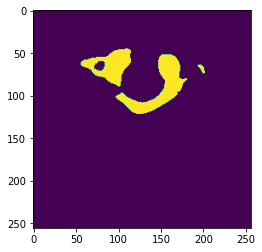

In [116]:
plt.imshow(targets[3][0][:, :, 31])

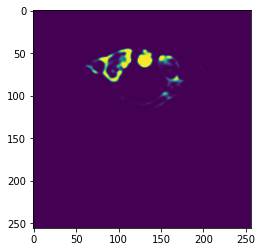

In [115]:
plt.imshow(outputs[3][0][:, :, 31])

In [21]:
def test_one_epoch(path, loader, running_dist=True, debug=False, do_ema=True):
    model = Model(pretrained=False)
    st = torch.load(path, map_location=f"cpu")
    model.eval()
    model.cuda()
    model.load_state_dict(st, strict=False)
    
    if is_main_process(): bar = tqdm(loader, bar_format='{n_fmt}/{total_fmt} {elapsed}<{remaining} {postfix}')
    else: bar = loader
    
    running_loss = 0.
    
    OUTPUTS, TARGETS, IDS = [], [], []
    
    for step, data in enumerate(bar):
        
        with torch.no_grad():
            images = data['images'].cuda()
            targets = data['labels'].cuda()
            #targets_masks = data['masks'].cuda()
            ids = data['ids']
            
            with torch.cuda.amp.autocast(enabled=CFG.autocast):
                if do_ema:
                    with ema.average_parameters():
                        logits, logits_mask = model(images)
                else:
                    logits, logits_mask = model(images)
                
            return logits, logits_mask
                
            outputs = logits.float().detach().cpu().numpy()
            targets = targets.float().detach().cpu().numpy()
            #outputs = logits_mask.float().sigmoid().detach().cpu()#.numpy()
            #targets = targets_masks.float().detach().cpu()#.numpy()
            
            #'''
            if running_dist:
                dist.barrier()
                
                np.save(f'{CFG.cache_dir}/preds_{get_rank()}.npy', outputs)
                np.save(f'{CFG.cache_dir}/targets_{get_rank()}.npy', targets)
                np.save(f'{CFG.cache_dir}/ids_{get_rank()}.npy', ids)
                
                dist.barrier()
                
                if is_main_process():
                    outputs = np.concatenate([np.load(f"{CFG.cache_dir}/preds_{_}.npy") for _ in range(CFG.N_GPUS)])
                    targets = np.concatenate([np.load(f"{CFG.cache_dir}/targets_{_}.npy") for _ in range(CFG.N_GPUS)])
                    ids = np.concatenate([np.load(f"{CFG.cache_dir}/ids_{_}.npy") for _ in range(CFG.N_GPUS)])
                    
                dist.barrier()
            else:    
                pass
            
            OUTPUTS.extend(outputs)
            TARGETS.extend(targets)
            IDS.extend(ids)
            #'''
            
            #if step==10: break
            
    if running_dist:
        dist.barrier()
    
    if is_main_process():
        OUTPUTS = np.stack(OUTPUTS)#[:, :6]
        TARGETS = np.stack(TARGETS)#[:, :6]
        IDS = np.stack(IDS)
        
        #return OUTPUTS, TARGETS, IDS
        
        score = np.mean(np.abs(OUTPUTS-TARGETS))
        
        print(f"EPOCH {CFG.epoch+1} | MAE {score}")
    
        if debug:
            return score, OUTPUTS, TARGETS, IDS
    
        return score
    
    if debug:
        return [], [], [], []

In [39]:
logits, logits_mask = test_one_epoch('./data/AAA_SEG/TRY1_SEG/tf_efficientnetv2_s.in21k_ft_in1k_v2/3_best.pth', valid_loader, do_ema=False, debug=True, running_dist=False)

0/104 00:00<? 


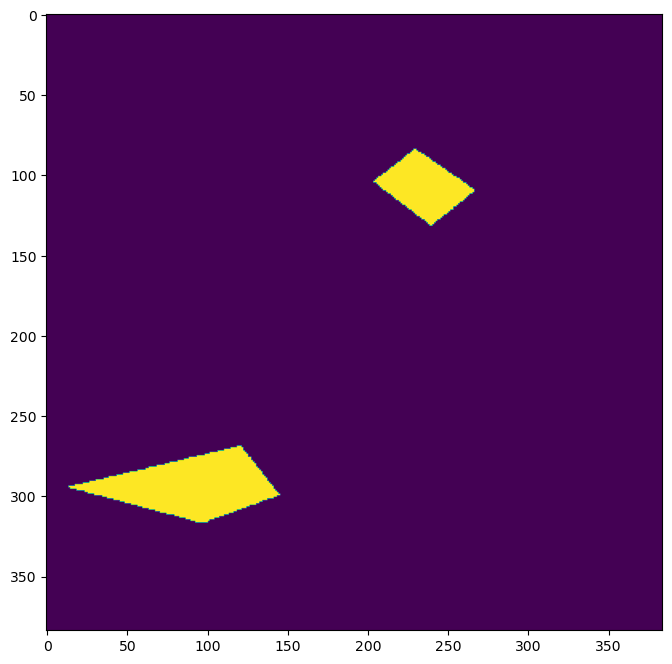

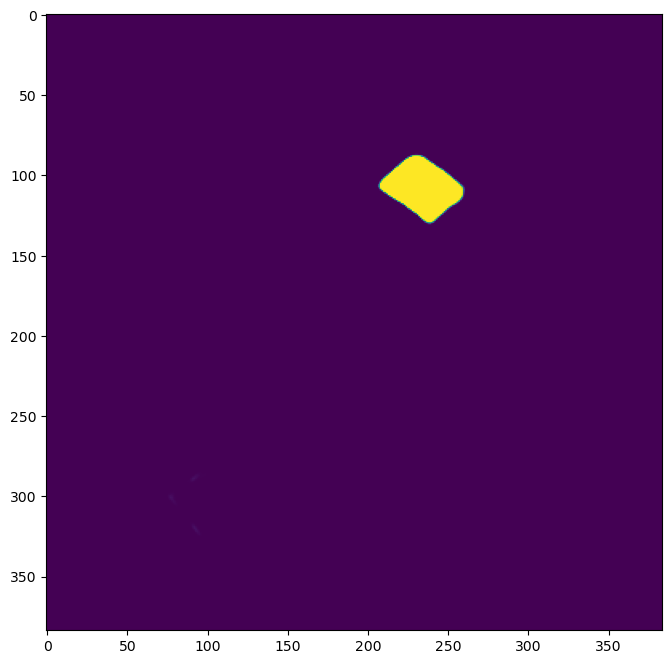

In [46]:
x = 5
plt.imshow(d['masks'][x][1]); plt.show()
plt.imshow(logits_mask.sigmoid()[x][1].detach().cpu()); plt.show()

In [22]:
score, OUTPUTS, TARGETS, IDS = test_one_epoch('./data/AAA_SEG/TRY1_SEG/tf_efficientnetv2_s.in21k_ft_in1k_v1/0_best.pth', valid_loader, do_ema=False, debug=True, running_dist=False)

0/104 00:00<? 


ValueError: not enough values to unpack (expected 4, got 2)

In [100]:
np.abs(np.round(OUTPUTS[:, 0]) - TARGETS[:, 0]).mean()

0.17028986

In [99]:
np.abs(np.round(OUTPUTS[:, 1]) - TARGETS[:, 1]).mean()

3.607488

In [104]:
np.abs(TARGETS[:, 0].mean() - TARGETS[:, 0]).mean()

0.42340544

In [105]:
np.abs(TARGETS[:, 1].mean() - TARGETS[:, 1]).mean()

6.549333

In [95]:
np.round(OUTPUTS[:, 1], 0)

array([ 1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  2.,  4.,  0.,  1.,  2.,
        1.,  2.,  1.,  1.,  2.,  2.,  0.,  4.,  1.,  7.,  3.,  1.,  2.,
        3.,  1.,  1.,  2.,  0.,  4.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,
        0.,  1.,  1.,  2.,  1.,  0.,  2.,  3.,  1.,  2.,  3.,  1.,  2.,
        1.,  2.,  1.,  1.,  1.,  1.,  2.,  1., 11.,  1.,  1.,  1.,  2.,
        1.,  1.,  3.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  3.,  1.,  1.,
        1.,  1.,  0.,  6.,  1.,  1.,  0.,  3.,  1.,  1., 48.,  1.,  0.,
        1.,  1.,  0.,  1.,  3.,  2.,  1.,  2.,  7.,  1.,  2.,  2.,  1.,
        1.,  0.,  1.,  3.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,
        5.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  2.,  2.,  0.,
        2.,  2.,  1.,  4.,  2.,  1.,  1.,  2.,  1.,  0.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  1.,  3.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,
        5.,  8.,  3.,  1.,  6.,  4.,  0.,  1.,  1.,  3.,  2.,  2.,  2.,
        1.,  1.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,  5.,  1.,  0

In [93]:
TARGETS[:, 1]

array([  2.,   1.,   1.,   5.,   1.,   2.,   1.,   1.,   2.,   1., 174.,
         1.,   2.,   1.,   2.,   1.,   3.,   2.,   1.,   0.,   2.,   1.,
        14.,   6.,   2.,   1.,   4.,   1.,   1.,   2.,   0.,   4.,   0.,
         1.,   2.,   2.,   2.,   4.,   2.,   0.,   1.,   1.,   3.,   6.,
         0.,   4.,   4.,   1.,   1.,   5.,   1.,   3.,   2.,   2.,   1.,
         2.,   1.,   1.,   1.,   2.,  18.,   1.,   1.,   1.,   3.,   2.,
         2.,   5.,   1.,   2.,   1.,   2.,   1.,   2.,   1.,  18.,   1.,
         1.,   1.,   2.,   0.,  12.,   2.,   1.,   0.,  13.,   1.,   1.,
       171.,   1.,   6.,   2.,   1.,   0.,   1.,   5.,   2.,   2.,   2.,
        17.,   4.,  32.,   3.,   1.,   2.,   0.,   2.,   6.,   1.,   2.,
         2.,   5.,   2.,   0.,   1.,   0.,   3.,   7.,   8.,   1.,   3.,
         2.,   5.,   1.,   3.,   1.,   0.,   4.,   2.,   4.,   2.,   2.,
         2.,   4.,   3.,   1.,   1.,   2.,   1.,   0.,   1.,   1.,   1.,
         7.,   1.,  10.,   0.,   3.,   5.,   1.,   

In [82]:
TARGETS[:, 1].mean()

5.5519323

In [20]:
score, OUTPUTS, TARGETS, IDS = test_one_epoch('./data/AAA_CLS/TRY1_CLS/tf_efficientnetv2_s.in21k_ft_in1k_v2/0_best.pth', valid_loader, do_ema=False, debug=True, running_dist=False)

86/86 00:04<00:00 

EPOCH 1 | AUC 0.9988291900561347


In [26]:
OUTPUTS[TARGETS==0]

array([5.40763059e-11, 2.59097945e-03, 2.60703091e-05, 7.42638076e-05,
       5.29661384e-06, 1.83428929e-05, 2.47727172e-07, 1.78131129e-04,
       9.61024198e-05, 3.87476146e-04, 9.62564215e-08, 2.04203320e-06,
       2.79693013e-05, 2.25558182e-07, 1.30329747e-04, 7.62598110e-11,
       8.53032088e-06, 1.34404097e-08, 6.47594788e-07, 2.62747726e-05,
       9.62212624e-04, 4.57539136e-05, 1.35743306e-07, 9.11051175e-04,
       1.47924666e-07, 1.27787280e-06, 5.91419979e-13, 6.24093036e-06,
       2.21256687e-05, 6.21478264e-08, 9.06971912e-14, 1.21130643e-03,
       1.66139065e-03, 4.13353991e-05, 3.07743088e-04, 1.05432015e-12,
       2.52682275e-05, 4.40011863e-05, 9.02803804e-05, 6.25371322e-05,
       1.81408182e-01, 1.67014205e-05, 3.33656307e-14, 9.57675397e-01,
       2.78030959e-04, 5.44213282e-04, 1.79179879e-05, 1.08451673e-06,
       4.03779013e-05, 7.06640072e-03, 1.47389828e-05, 6.64104824e-04,
       1.92602864e-04, 9.18485270e-08, 8.99096108e-07, 1.32381858e-04,
      

In [25]:
np.sum(TARGETS==0, 0)

array([186, 285, 515])

In [37]:
TARGETS[(TARGETS[:, 0]==0) & (TARGETS[:, 2]!=1.)]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [35]:
TARGETS[(TARGETS[:, 1]==0) & (TARGETS[:, 2]!=1.)]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [42]:
np.round(OUTPUTS[(TARGETS[:, 0]==0) & (TARGETS[:, 2]!=1.)], 3)

array([[0.958, 1.   , 0.   ],
       [0.925, 0.997, 0.001],
       [0.702, 0.999, 0.005],
       [0.892, 0.998, 0.003],
       [0.921, 0.995, 0.002],
       [0.85 , 1.   , 0.001],
       [0.923, 0.999, 0.001],
       [0.944, 1.   , 0.   ],
       [0.922, 1.   , 0.   ],
       [0.954, 1.   , 0.   ],
       [0.891, 1.   , 0.002],
       [0.868, 1.   , 0.001],
       [0.899, 0.942, 0.009],
       [1.   , 0.999, 0.   ]], dtype=float32)

In [58]:
np.round(OUTPUTS[(TARGETS[:, 1]==0) & (TARGETS[:, 2]!=1.)], 3)

array([[1.   , 0.   , 0.   ],
       [1.   , 0.181, 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.992, 0.286, 0.001],
       [0.998, 0.239, 0.   ],
       [0.981, 0.6  , 0.002],
       [0.992, 0.229, 0.001],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.995, 0.161, 0.001],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.001, 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.999, 0.168, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.

In [21]:
OUTPUTS[TARGETS==1]

array([0.9999733 , 1.        , 0.7049733 , ..., 0.9999286 , 0.99997854,
       0.9999826 ], dtype=float32)